
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [50]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, r2_score, mean_squared_error, f1_score
from plotnine import *
import matplotlib.pyplot as plt

In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [61]:
ha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


# KNN

In [64]:
X = ha.drop(columns='cp')
y = ha['cp']

In [6]:
# KNN pipe

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

knn_pipe = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsClassifier())]
).set_output(transform="pandas")

In [8]:
# fitting model on KNN 5 and reporting scores

knn_5 = knn_pipe.set_params(knn__n_neighbors=5)
y_pred_5 = cross_val_predict(knn_5, X, y, cv=5)
cm_knn5 = confusion_matrix(y, y_pred_5)

# scores
print("Accuracy score: ", accuracy_score(y, y_pred_5))
print("Classification Report:\n", classification_report(y, y_pred_5))

Accuracy score:  0.45787545787545786
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.74      0.66       128
           1       0.19      0.16      0.17        44
           2       0.31      0.27      0.29        81
           3       0.50      0.05      0.09        20

    accuracy                           0.46       273
   macro avg       0.40      0.31      0.30       273
weighted avg       0.43      0.46      0.43       273



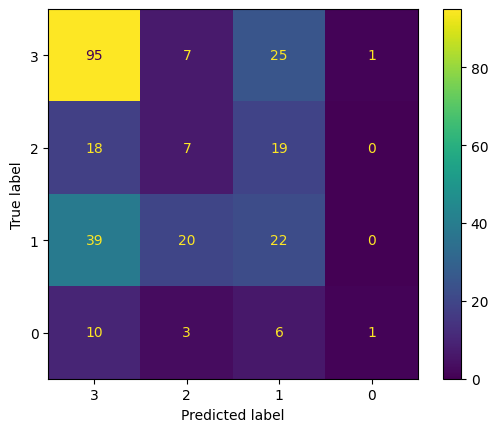

In [9]:
# confusion matrix plot

labels = ha["cp"].unique()

ConfusionMatrixDisplay(cm_knn5, display_labels = labels).plot()

Best KNN tuning

In [10]:
param_grid = {
    'knn__n_neighbors': range(1,36)
}

In [11]:
gsvc = GridSearchCV(knn_pipe, param_grid, cv=5, scoring='accuracy')
gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score: ", gsvc.best_score_)
# KNN: n=33

{'knn__n_neighbors': 33}
0.5494949494949495


In [13]:
# y_pred with best knn cross_val_predict
best_knn = gsvc.best_estimator_
y_pred = cross_val_predict(best_knn, X, y, cv=5)
cm_best_knn = confusion_matrix(y, y_pred)

# scores
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

Accuracy score:  0.5494505494505495
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.79      0.70       128
           1       0.50      0.18      0.27        44
           2       0.42      0.51      0.46        81
           3       0.00      0.00      0.00        20

    accuracy                           0.55       273
   macro avg       0.39      0.37      0.36       273
weighted avg       0.50      0.55      0.51       273



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


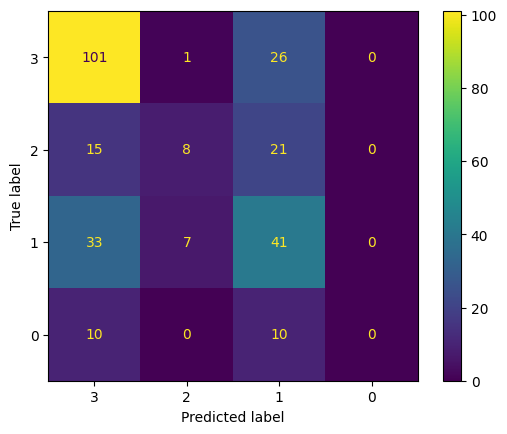

In [14]:
# Best KNN confustion matrix

labels = ha['cp'].unique()
ConfusionMatrixDisplay(cm_best_knn, display_labels = labels).plot()

# Decision Tree

In [65]:
# DecisionTree pipe

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

tree_pipe = Pipeline(
  [("preprocessing", ct),
  ("tree", DecisionTreeClassifier())]
).set_output(transform="pandas")

In [78]:
# tunning decision tree model with multiple parameters # note: params suggested by ChatGPT

param_grid = {
    'tree__min_samples_leaf': [1, 2, 3, 5],
    'tree__max_depth': [2, 3, 4, 5],
    'tree__ccp_alpha': [0.0, 0.01, 0.02, 0.05, 0.10],
    'tree__min_impurity_decrease': [0.0, 0.01, 0.05]
}

gsvc = GridSearchCV(tree_pipe, param_grid, cv=5, scoring='accuracy')
gsvc.fit(X, y)


print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score: ", gsvc.best_score_)

# Best parameters:  {'tree__max_depth': 2, 'tree__min_impurity_decrease': 0.05, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
# Best cross-validation score:  0.5752188552188552

Best parameters:  {'tree__ccp_alpha': 0.0, 'tree__max_depth': 2, 'tree__min_impurity_decrease': 0.05, 'tree__min_samples_leaf': 1}
Best cross-validation score:  0.5752188552188552


In [79]:
# y_pred with best dt cross_val_predict
best_tree = gsvc.best_estimator_
y_pred = cross_val_predict(best_tree, X, y, cv=5)
cm_best_tree = confusion_matrix(y, y_pred)

# scores
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

Accuracy score:  0.575091575091575
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74       128
           1       0.00      0.00      0.00        44
           2       0.43      0.78      0.56        81
           3       0.00      0.00      0.00        20

    accuracy                           0.58       273
   macro avg       0.29      0.38      0.32       273
weighted avg       0.48      0.58      0.51       273



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


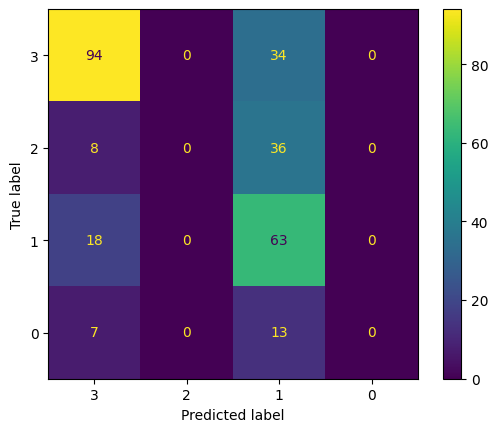

In [80]:
# Best Tree confustion matrix

labels = ha['cp'].unique()
ConfusionMatrixDisplay(cm_best_tree, display_labels = labels).plot()

In [53]:
best_tree.named_steps['tree']

DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.05)

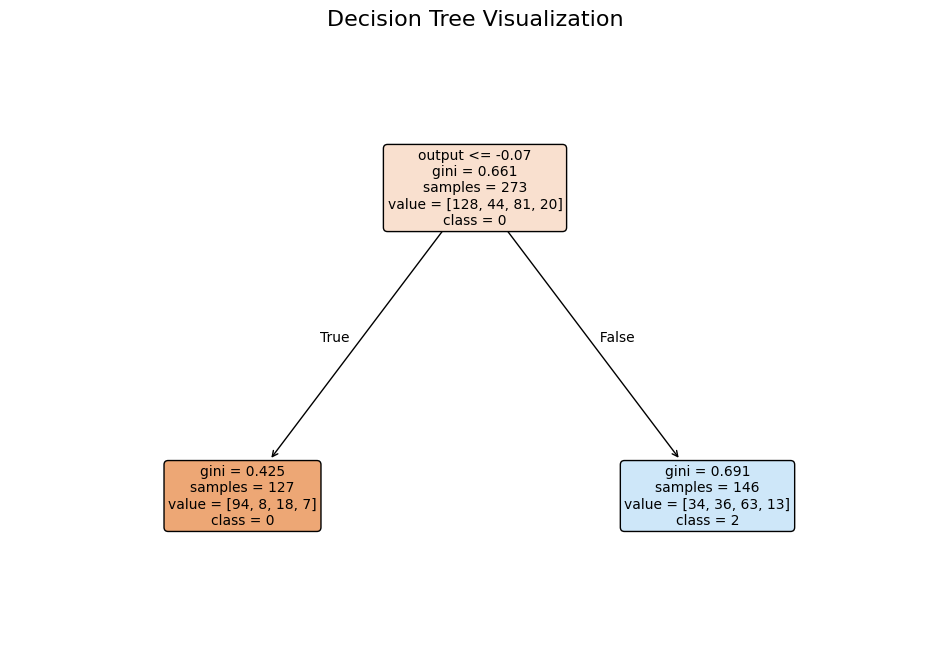

In [81]:
# Plot best decision tree # Assissted by ChatGPT
b_tree = best_tree.named_steps['tree']

plt.figure(figsize=(12,8))
plot_tree(
    b_tree,
    feature_names = X.columns,
    class_names=[str(cls) for cls in sorted(y.unique())],
    filled=True,
    rounded=True,
    fontsize=10

)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()

# LDA

In [25]:
# LDA pipe

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

lda_pipe = Pipeline([
    ('preprocessing', ct),
    ('lda', LinearDiscriminantAnalysis())
]).set_output(transform="pandas")

In [43]:
# tunning LDA model with multiple parameters # note: params suggested by ChatGPT

param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],
    'lda__shrinkage': [None, 'auto'],
    'lda__n_components': [None]
}

gsvc = GridSearchCV(lda_pipe, param_grid, cv=5, scoring='accuracy')
gsvc.fit(X, y)


print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score: ", gsvc.best_score_)
# Best parameters:  {'lda__n_components': None, 'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}
# Best cross-validation score:  0.5533333333333333

Best parameters:  {'lda__n_components': None, 'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}
Best cross-validation score:  0.5533333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python

In [44]:
# y_pred with best dt cross_val_predict
best_lda = gsvc.best_estimator_
y_pred = cross_val_predict(best_lda, X, y, cv=5)
cm_best_lda = confusion_matrix(y, y_pred)

# scores
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

Accuracy score:  0.5531135531135531
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72       128
           1       0.36      0.09      0.15        44
           2       0.42      0.64      0.51        81
           3       0.00      0.00      0.00        20

    accuracy                           0.55       273
   macro avg       0.37      0.37      0.34       273
weighted avg       0.51      0.55      0.51       273



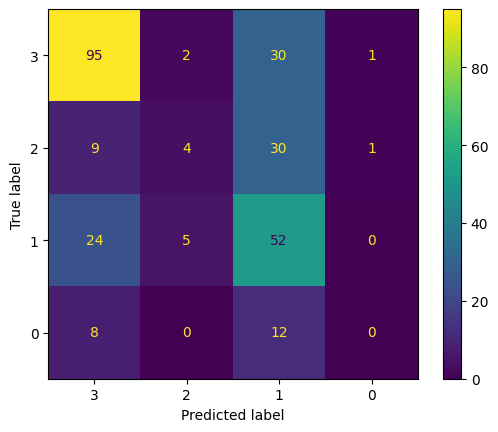

In [45]:
# Best Tree confustion matrix

labels = ha['cp'].unique()
ConfusionMatrixDisplay(cm_best_lda, display_labels = labels).plot()

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [82]:
# add new columns
ha['cp_is_3'] = (ha['cp'] == 3)*1
ha['cp_is_2'] = (ha['cp'] == 2)*1
ha['cp_is_1'] = (ha['cp'] == 1)*1
ha['cp_is_0'] = (ha['cp'] == 0)*1

In [83]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2,cp_is_1,cp_is_0
0,63,1,3,145,233,0,150,1,1,0,0,0
1,37,1,2,130,250,1,187,1,0,1,0,0
2,56,1,1,120,236,1,178,1,0,0,1,0
3,57,0,0,120,354,1,163,1,0,0,0,1
4,57,1,0,140,192,1,148,1,0,0,0,1


## cp_is_3

In [84]:
X = ha.drop(columns=['cp_is_0','cp_is_1','cp_is_2','cp_is_3','cp'])
y = ha['cp_is_3']

In [85]:
# LogReg pipe

logreg_pipe = Pipeline([
    ('model', LogisticRegression())
]).set_output(transform="pandas")

fitted_logreg = logreg_pipe.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [86]:
# extract coefs for coefs from logistic regression
logreg_coefs = fitted_logreg.named_steps['model'].coef_
logreg_coefs

array([[ 0.01559898,  1.25240914,  0.02148186, -0.00544682, -0.21880069,
         0.01143524,  0.30753502]])

In [87]:
y_pred = cross_val_predict(logreg_pipe, X, y, cv=5)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/line

In [88]:
logreg_f1_cp3 = f1_score(y, y_pred)
logreg_f1_cp3

0.0

# cp_is_2

In [89]:
X = ha.drop(columns=['cp_is_0','cp_is_1','cp_is_2','cp_is_3','cp'])
y = ha['cp_is_2']

In [90]:
# LogReg pipe

logreg_pipe = Pipeline([
    ('model', LogisticRegression())
]).set_output(transform="pandas")

fitted_logreg = logreg_pipe.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [91]:
# extract coefs for coefs from logistic regression
logreg_coefs = fitted_logreg.named_steps['model'].coef_
logreg_coefs

array([[-0.00938299, -0.30396807, -0.00192668, -0.0028243 ,  0.19183569,
         0.00143984,  1.18647551]])

In [92]:
y_pred = cross_val_predict(logreg_pipe, X, y, cv=5)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/line

In [93]:
logreg_f1_cp2 = f1_score(y, y_pred)
logreg_f1_cp2

0.18604651162790697

# cp_is_1

In [94]:
X = ha.drop(columns=['cp_is_0','cp_is_1','cp_is_2','cp_is_3','cp'])
y = ha['cp_is_1']

In [95]:
# LogReg pipe

logreg_pipe = Pipeline([
    ('model', LogisticRegression())
]).set_output(transform="pandas")

fitted_logreg = logreg_pipe.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [96]:
# extract coefs for coefs from logistic regression
logreg_coefs = fitted_logreg.named_steps['model'].coef_
logreg_coefs

array([[-0.00692184,  0.31686664, -0.01097912,  0.00194941,  0.57590983,
         0.02017802,  0.96426962]])

In [97]:
y_pred = cross_val_predict(logreg_pipe, X, y, cv=5)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/line

In [98]:
logreg_f1_cp1 = f1_score(y, y_pred)
logreg_f1_cp1

0.0

# cp_is_0

In [99]:
X = ha.drop(columns=['cp_is_0','cp_is_1','cp_is_2','cp_is_3','cp'])
y = ha['cp_is_0']

In [100]:
# LogReg pipe

logreg_pipe = Pipeline([
    ('model', LogisticRegression())
]).set_output(transform="pandas")

fitted_logreg = logreg_pipe.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [101]:
# extract coefs for coefs from logistic regression
logreg_coefs = fitted_logreg.named_steps['model'].coef_
logreg_coefs

array([[ 1.69889892e-02, -1.19984986e-01,  7.14417780e-04,
         4.26779344e-03, -1.97234584e-01, -1.31542734e-02,
        -1.75288134e+00]])

In [102]:
y_pred = cross_val_predict(logreg_pipe, X, y, cv=5)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/line

In [103]:
logreg_f1_cp0 = f1_score(y, y_pred)
logreg_f1_cp0

0.7058823529411765

In [104]:
# df_f1_ovr
df_f1_ovr = pd.DataFrame(
    {'LogReg model target': ['cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'],
      'F1 score': [logreg_f1_cp0, logreg_f1_cp1, logreg_f1_cp2, logreg_f1_cp3]}
)
df_f1_ovr


,LogReg model target,F1 score
0,cp_is_0,0.705882
1,cp_is_1,0.000000
2,cp_is_2,0.186047
3,cp_is_3,0.000000


high F1 (0.7) only for CP_is_0 in LogReg model with OvR approach

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

## CP [0,1]

In [105]:
# reduced dataset to 0,1 cp obs

ha_01 = ha[ha['cp'].isin([0,1])]
ha_01.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2,cp_is_1,cp_is_0
2,56,1,1,120,236,1,178,1,0,0,1,0
3,57,0,0,120,354,1,163,1,0,0,0,1
4,57,1,0,140,192,1,148,1,0,0,0,1
5,56,0,1,140,294,0,153,1,0,0,1,0
6,44,1,1,120,263,1,173,1,0,0,1,0


In [106]:
X = ha_01.drop(columns=['cp_is_0','cp_is_1','cp_is_2','cp_is_3','cp'])
y = ha_01['cp']

In [109]:
fitted_logreg = logreg_pipe.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [110]:
logreg_coefs = fitted_logreg.named_steps['model'].coef_
logreg_coefs

array([[-3.06196964e-02,  2.98184371e-01, -5.01270275e-03,
        -8.13269706e-04,  5.19652971e-01,  2.07434556e-02,
         1.66391626e+00]])

In [111]:
y_pred = cross_val_predict(logreg_pipe, X, y, cv=5)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/line

In [113]:
y_score_1 = cross_val_score(fitted_logreg, X, y, cv=5, scoring="roc_auc")
y_score_1.mean()
# 0.8010683760683761


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/line

array([0.65811966, 0.91025641, 0.89333333, 0.99555556, 0.54807692])

## CP[0,2]

In [114]:
# reduced dataset to 0,2 cp obs

ha_02 = ha[ha['cp'].isin([0,2])]
ha_02.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2,cp_is_1,cp_is_0
1,37,1,2,130,250,1,187,1,0,1,0,0
3,57,0,0,120,354,1,163,1,0,0,0,1
4,57,1,0,140,192,1,148,1,0,0,0,1
7,52,1,2,172,199,1,162,1,0,1,0,0
8,57,1,2,150,168,1,174,1,0,1,0,0


In [115]:
X = ha_02.drop(columns=['cp_is_0','cp_is_1','cp_is_2','cp_is_3','cp'])
y = ha_02['cp']

In [116]:
fitted_logreg = logreg_pipe.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [117]:
y_score_2 = cross_val_score(fitted_logreg, X, y, cv=5, scoring="roc_auc")
y_score_2.mean()
# 0.7049773755656108

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/line

0.7049773755656108

## CP [0,3]

In [118]:
# reduced dataset to 0,3 cp obs

ha_03 = ha[ha['cp'].isin([0,3])]
ha_03.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2,cp_is_1,cp_is_0
0,63,1,3,145,233,0,150,1,1,0,0,0
3,57,0,0,120,354,1,163,1,0,0,0,1
4,57,1,0,140,192,1,148,1,0,0,0,1
9,54,1,0,140,239,1,160,1,0,0,0,1
12,58,0,3,150,283,0,162,1,1,0,0,0


In [119]:
X = ha_03.drop(columns=['cp_is_0','cp_is_1','cp_is_2','cp_is_3','cp'])
y = ha_03['cp']

In [120]:
fitted_logreg = logreg_pipe.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [122]:
y_score_3 = cross_val_score(fitted_logreg, X, y, cv=5, scoring="roc_auc")
y_score_3.mean()
# 0.7313846153846154

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/line

0.7313846153846154

With OvO method, all predictions had a significantly higher score than with OvR > 0.7.
The highest ROC AUC score 0.801 was for 'cp' [0, 1] pair.